In [36]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az

from scipy.stats import poisson

from matplotlib import pyplot as plt

In [37]:
teams = pd.read_csv('data/teams.csv').convert_dtypes()
results = pd.read_csv('data/results.csv').convert_dtypes()
fixtures = pd.read_csv('data/fixtures.csv').convert_dtypes()

In [38]:
# For this case need to create a team ID map from 0 to 27, instead of 1 to 28 for tensor calculation
# Create a mapping from team IDs to consecutive integers
team_id_map = {team_id: i for i, team_id in enumerate(teams['TeamID'].unique())}
results['HomeTeamIdx'] = results['HomeTeamID'].map(team_id_map)
results['AwayTeamIdx'] = results['AwayTeamID'].map(team_id_map)
fixtures['HomeTeamIdx'] = fixtures['HomeTeamID'].map(team_id_map)
fixtures['AwayTeamIdx'] = fixtures['AwayTeamID'].map(team_id_map)

# Calculate total goals scored and conceded by each team in home and away matches
team_stats_home = results.groupby('HomeTeamIdx').agg({'HomeScore': 'sum', 'AwayScore': 'sum', 'HomeTeamIdx': 'count'}).rename(columns={'HomeScore': 'home_goals_scored', 'AwayScore': 'home_goals_conceded', 'HomeTeamIdx': 'home_games_played'}).reset_index()
team_stats_away = results.groupby('AwayTeamIdx').agg({'HomeScore': 'sum', 'AwayScore': 'sum', 'AwayTeamIdx': 'count'}).rename(columns={'HomeScore': 'away_goals_conceded', 'AwayScore': 'away_goals_scored', 'AwayTeamIdx': 'away_games_played'}).reset_index()

# Merge home and away stats
team_stats = pd.merge(team_stats_home, team_stats_away, left_on='HomeTeamIdx', right_on='AwayTeamIdx')

# Calculate league averages and standard deviations aggregated by HomeTeamIdx and AwayTeamIdx
league_avg_home_goals = team_stats['home_goals_scored'].mean()
league_avg_away_goals = team_stats['away_goals_scored'].mean()
league_std_home_goals = team_stats['home_goals_scored'].std()
league_std_away_goals = team_stats['away_goals_scored'].std()

# Convert team indices to numpy arrays
home_team_ids = results['HomeTeamIdx'].values
away_team_ids = results['AwayTeamIdx'].values

In [39]:
# Define the PyMC model
with pm.Model() as model:
  
    # Hyperpriors for the Gamma distribution of team strengths
    alpha_home_scored = (league_avg_home_goals / league_std_home_goals) ** 2
    beta_home_scored = league_avg_home_goals / (league_std_home_goals ** 2)
    
    alpha_away_scored = (league_avg_away_goals / league_std_away_goals) ** 2
    beta_away_scored = league_avg_away_goals / (league_std_away_goals ** 2)
    
    alpha_home_conceded = (league_avg_away_goals / league_std_away_goals) ** 2
    beta_home_conceded = league_avg_away_goals / (league_std_away_goals ** 2)
    
    alpha_away_conceded = (league_avg_home_goals / league_std_home_goals) ** 2
    beta_away_conceded = league_avg_home_goals / (league_std_home_goals ** 2)
    
    # Priors for team strengths
    home_scoring_strength = pm.Gamma('home_scoring_strength', alpha_home_scored, beta_home_scored, shape=len(teams))
    away_scoring_strength = pm.Gamma('away_scoring_strength', alpha_away_scored, beta_away_scored, shape=len(teams))
    home_defensive_strength = pm.Gamma('home_defensive_strength', alpha_home_conceded, beta_home_conceded, shape=len(teams))
    away_defensive_strength = pm.Gamma('away_defensive_strength', alpha_away_conceded, beta_away_conceded, shape=len(teams))
    
    # Likelihood for observed goals
    home_goals = pm.Poisson('home_goals', mu=home_scoring_strength[home_team_ids] * away_defensive_strength[away_team_ids], observed=results['HomeScore'].values)
    away_goals = pm.Poisson('away_goals', mu=away_scoring_strength[away_team_ids] * home_defensive_strength[home_team_ids], observed=results['AwayScore'].values)
    

    # Sample from the posterior
    trace = pm.sample(4000, tune=4000, chains=4, cores=4, init='jitter+adapt_diag', return_inferencedata=True)
    ppc = pm.sample_posterior_predictive(trace, var_names=['home_scoring_strength', 'away_scoring_strength', 'home_defensive_strength', 'away_defensive_strength'], random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home_scoring_strength, away_scoring_strength, home_defensive_strength, away_defensive_strength]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

In [ ]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
ppc

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

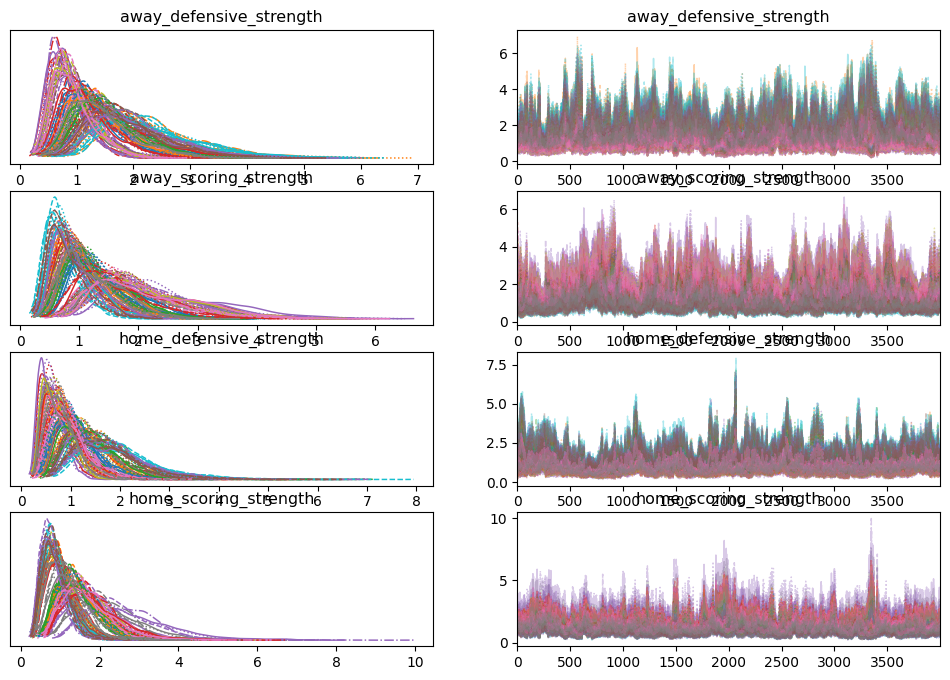

/Users/ahasib/Library/Caches/pypoetry/virtualenvs/pythia-soccer-BGTKE3L9-py3.10/lib/python3.10/site-packages/arviz/plots/plot_utils.py:272: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (448) in plot_autocorr, generating only 40 plots
  warnings.warn(


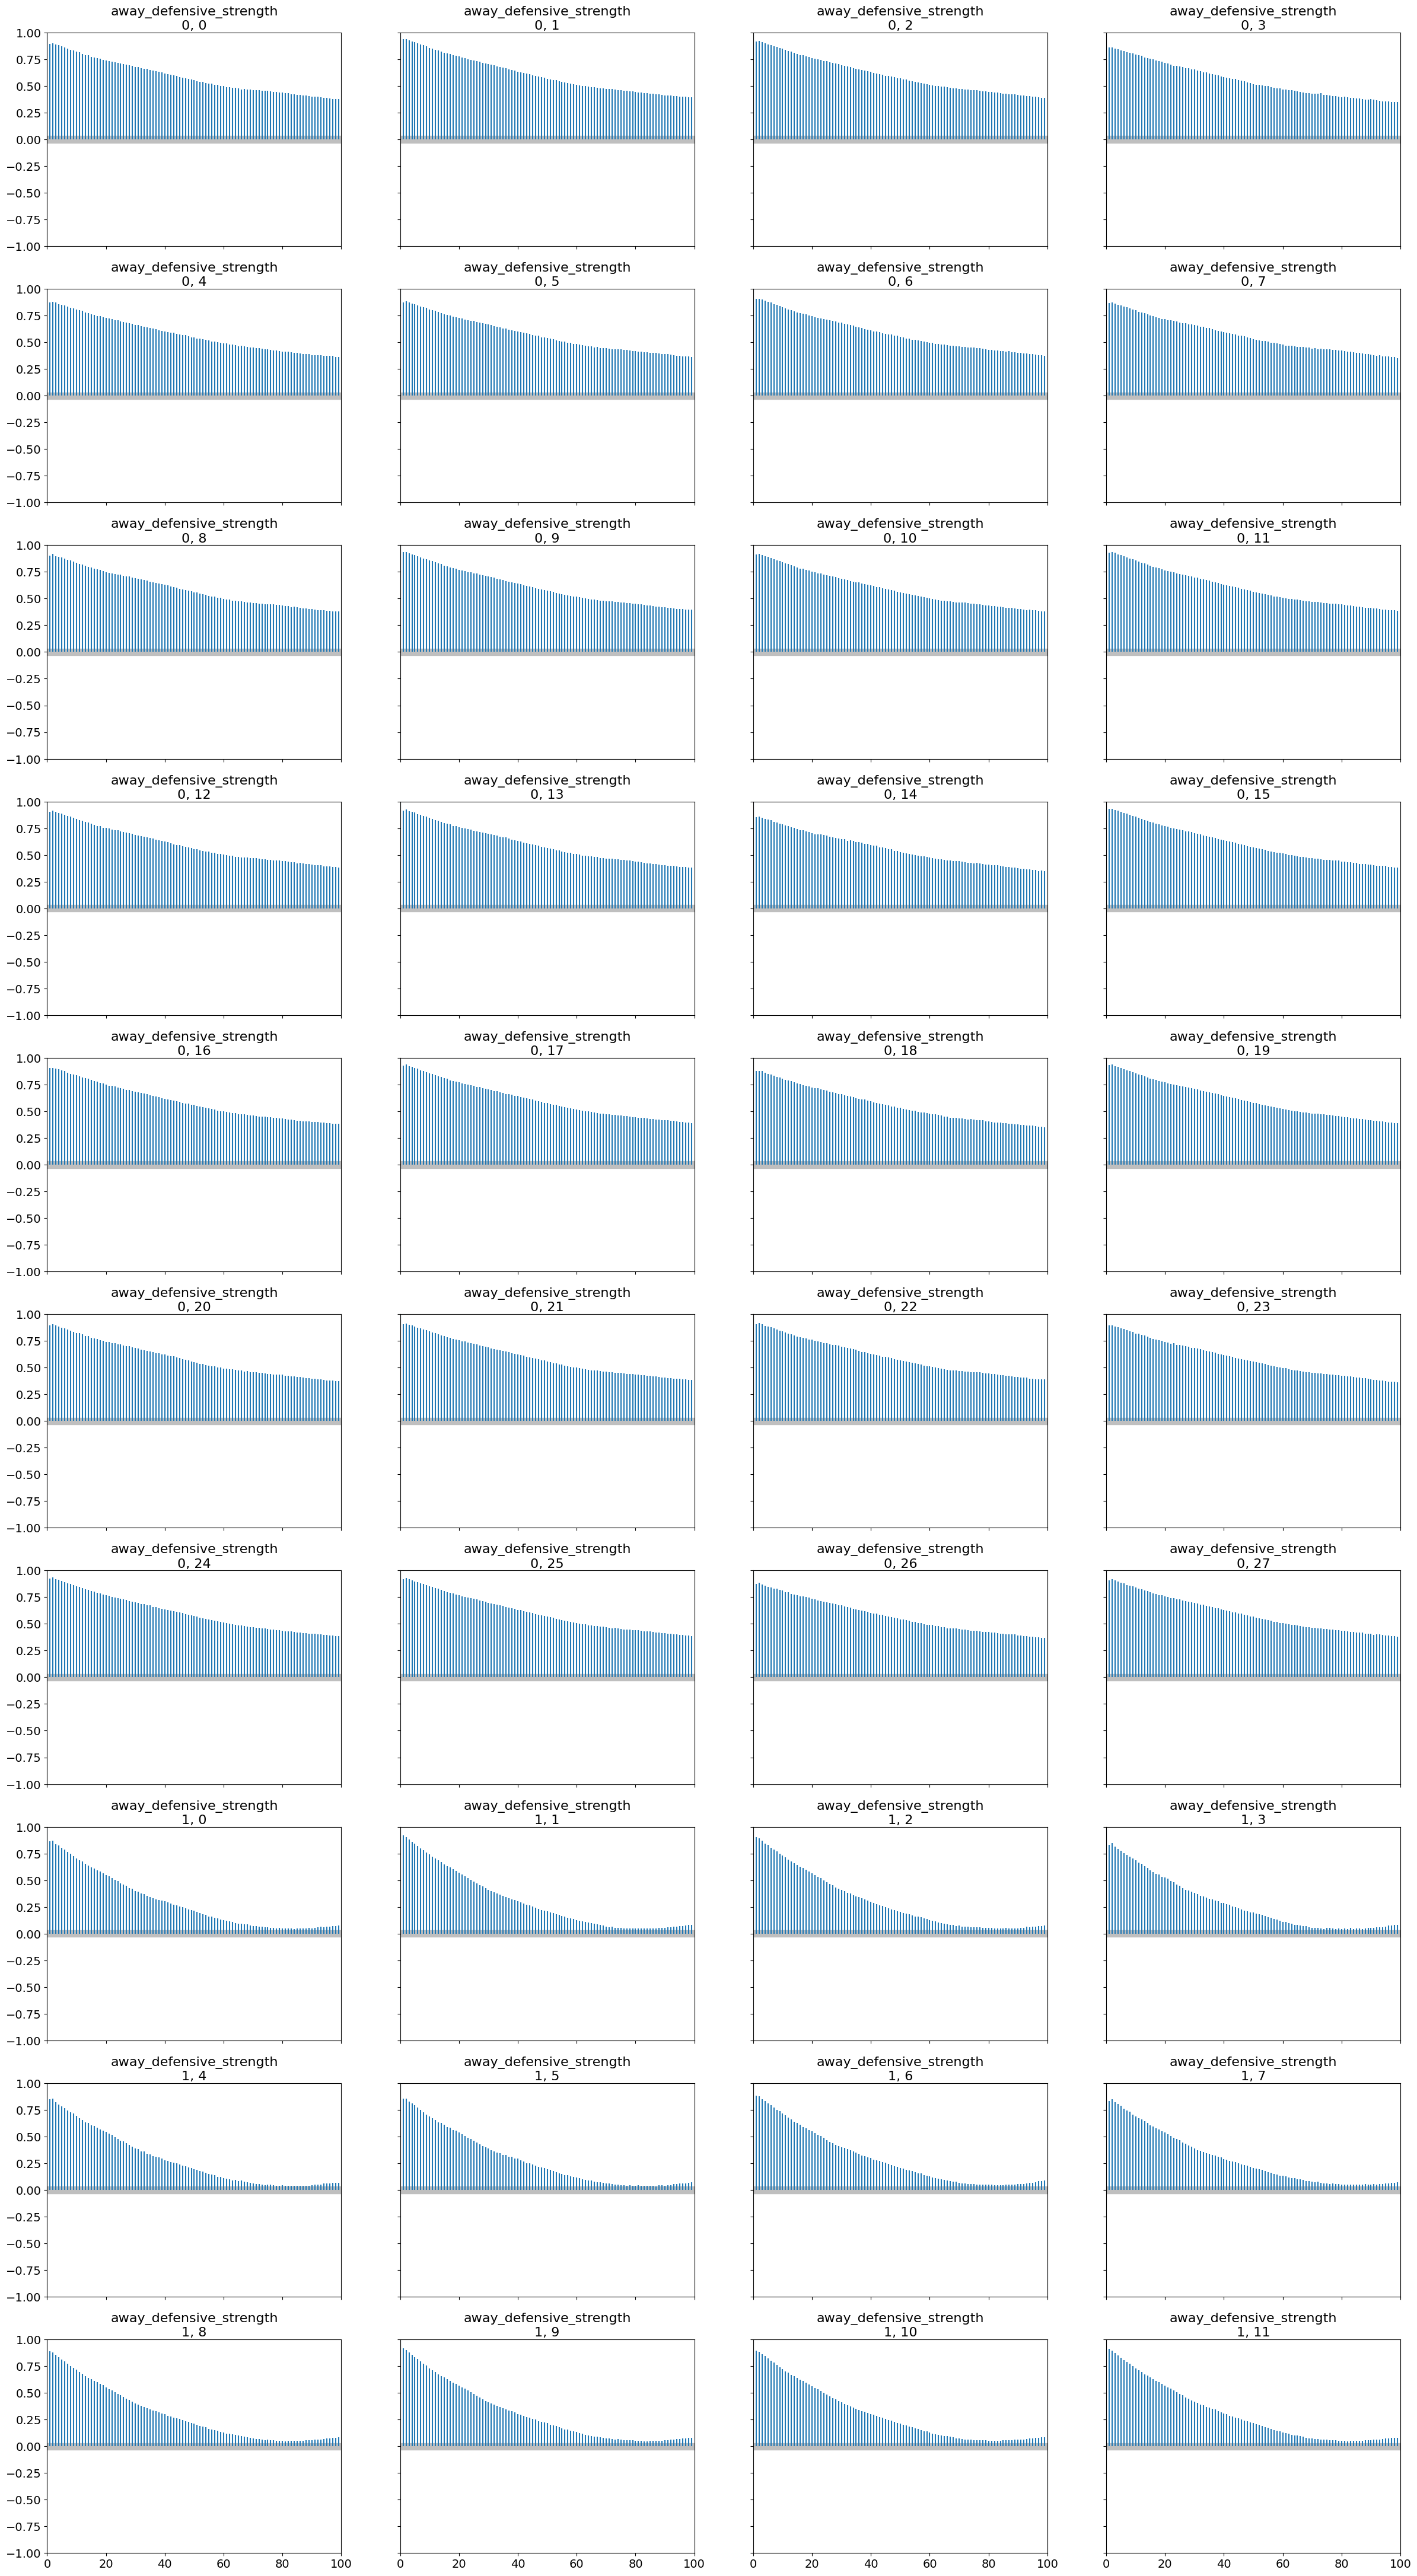

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
away_defensive_strength[0],1.250,0.477,0.472,2.146,0.044,0.031,114.0,340.0,1.01
away_defensive_strength[1],2.333,0.867,0.973,4.041,0.081,0.058,109.0,316.0,1.01
away_defensive_strength[2],1.701,0.640,0.695,2.949,0.059,0.042,111.0,299.0,1.01
away_defensive_strength[3],0.833,0.328,0.300,1.438,0.029,0.021,119.0,336.0,1.01
away_defensive_strength[4],1.035,0.399,0.409,1.808,0.036,0.026,116.0,337.0,1.01
...,...,...,...,...,...,...,...,...,...
home_scoring_strength[23],1.759,0.671,0.687,2.926,0.062,0.044,111.0,326.0,1.01
home_scoring_strength[24],0.815,0.322,0.314,1.383,0.029,0.021,117.0,330.0,1.01
home_scoring_strength[25],0.868,0.341,0.334,1.474,0.031,0.022,117.0,342.0,1.01
home_scoring_strength[26],1.628,0.621,0.624,2.697,0.058,0.041,110.0,315.0,1.01


In [ ]:


# Trace plots
az.plot_trace(trace)
plt.show()

# Autocorrelation plots
az.plot_autocorr(trace)
plt.show()

# Summary statistics including R-hat and ESS
summary = az.summary(trace)
display(summary)


In [ ]:
  
idata = ppc
idata.extend(trace)

# Predict goals for fixtures
home_team_ids = fixtures['HomeTeamIdx'].values
away_team_ids = fixtures['AwayTeamIdx'].values

predicted_home_goals = np.zeros(len(fixtures))
predicted_away_goals = np.zeros(len(fixtures))

for i in range(len(fixtures)):
    home_strength_samples = idata.posterior_predictive['home_goals'].values[:, i]
    away_defense_samples = idata.posterior_predictive['away_goals'].values[:, i]
    away_strength_samples = idata.posterior_predictive['away_goals'].values[:, i]
    home_defense_samples = idata.posterior_predictive['home_goals'].values[:, i]
    
    predicted_home_goals[i] = np.mean(home_strength_samples * away_defense_samples)
    predicted_away_goals[i] = np.mean(away_strength_samples * home_defense_samples)

# Save the predicted outcomes
predicted_fixtures = fixtures.copy()
predicted_fixtures['predicted_home_goals'] = predicted_home_goals
predicted_fixtures['predicted_away_goals'] = predicted_away_goals

KeyError: "No variable named 'home_goals'. Variables on the dataset include ['chain', 'draw', 'away_defensive_strength_dim_2', 'away_defensive_strength', 'away_scoring_strength_dim_2', 'away_scoring_strength', 'home_defensive_strength_dim_2', 'home_defensive_strength', 'home_scoring_strength_dim_2', 'home_scoring_strength']"

In [ ]:
predict_actual_results = predicted_fixtures.merge(results[['MatchID', 'HomeScore', 'AwayScore']])
# Calculate actual and predicted match points: win 3 , draw 1 , loss 0

predict_actual_results['Actual_HomePoints'] = predict_actual_results.apply(lambda x: 3 if x['HomeScore'] > x['AwayScore'] else (1 if x['HomeScore'] == x['AwayScore'] else 0), axis=1)
predict_actual_results['Actual_AwayPoints'] = predict_actual_results.apply(lambda x: 3 if x['HomeScore'] < x['AwayScore'] else (1 if x['HomeScore'] == x['AwayScore'] else 0), axis=1)

predict_actual_results['Pred_HomePoints'] = predict_actual_results.apply(lambda x: 3 if x['predicted_home_goals'] > x['predicted_away_goals'] else (1 if x['predicted_home_goals'] == x['predicted_away_goals'] else 0), axis=1)
predict_actual_results['Pred_AwayPoints'] = predict_actual_results.apply(lambda x: 3 if x['predicted_home_goals'] < x['predicted_away_goals'] else (1 if x['predicted_home_goals'] == x['predicted_away_goals'] else 0), axis=1)

predict_actual_results['Correct Match'] = predict_actual_results.apply(lambda x: 1 if x['Actual_HomePoints'] == x['Pred_HomePoints'] else 0, axis=1)

In [ ]:
predict_actual_results

,SeasonID,Gameweek,MatchID,HomeTeamID,AwayTeamID,HomeTeamIdx,AwayTeamIdx,predicted_home_goals,predicted_away_goals,HomeScore,AwayScore,Actual_HomePoints,Actual_AwayPoints,Pred_HomePoints,Pred_AwayPoints,Correct Match
0,2,1,757,2,1,1,0,8413.633929,5425.821429,1,2,0,3,3,0,0
1,2,1,758,28,3,27,2,8489.026786,4934.517857,5,1,3,0,3,0,1
2,2,1,759,27,4,26,3,8130.464286,4947.410714,0,1,0,3,3,0,0
3,2,1,760,26,5,25,4,8373.035714,4614.705357,2,6,0,3,3,0,0
4,2,1,761,25,6,24,5,8572.571429,5612.928571,0,3,0,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2,54,1508,10,19,9,18,8222.419643,5128.598214,0,6,0,3,3,0,0
752,2,54,1509,11,18,10,17,8737.901786,5427.491071,5,2,3,0,3,0,1
753,2,54,1510,12,17,11,16,8678.866071,5265.071429,3,3,1,1,3,0,0
754,2,54,1511,13,16,12,15,7809.910714,5419.642857,5,1,3,0,3,0,1


In [ ]:
predict_actual_results['Correct Match'].value_counts()


Correct Match
0    396
1    360
Name: count, dtype: int64